In [1]:
import os
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import appletree as apt
from appletree import randgen
from appletree import Context
from appletree.share import PARPATH, DATAPATH
from appletree.components import ERBand, AC

%matplotlib inline

In [2]:
# set GPU memory limit
apt.set_gpu_memory_usage(0.2)
# use XENON plot style
apt.use_xenon_plot_style()

In [3]:
# initialize context with parameter config
par_config = apt.utils.load_json(os.path.join(PARPATH, 'apt_sr0_er.json'))
context = Context(par_config)

In [4]:
# define likelihood
rn220_llh_config = dict(
    # path to the data file
    data_file_name = os.path.join(DATAPATH, 'data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv'), 
    # binning scheme, 'equiprob' or 'meshgrid'
    bins_type = 'equiprob',
    # dimensions where binning is applied on
    bins_on = ['cs1', 'cs2'],
    # number of bins if bins_type == 'equiprob'
    bins = [30, 30],
    # x range, i.e. cS1 range
    x_clip = [0, 100],
    # y range, i.e. cS2 range
    y_clip = [2e2, 1e4],
)

# register the likelihood to the posterior
context.register_likelihood('rn220_llh', rn220_llh_config)

# register ER component to rn220_llh
context.register_component('rn220_llh', ERBand, 'rn220_er', 'er_rate')
# register AC component to rn220_llh
context.register_component('rn220_llh', AC, 'rn220_ac', 'ac_rate')

In [5]:
context.print_context_summary()


LIKELIHOOD rn220_llh

----------------------------------------
BINNING

    bins_type: equiprob
    bins_on: ['cs1', 'cs2']

----------------------------------------
DATA

    file_name: /home/zihaoxu/appletree/appletree/data/data_XENONnT_Rn220_v8_strax_v1.2.2_straxen_v1.7.1_cutax_v1.9.0.csv
    data_rate: 2058.0

----------------------------------------
MODEL

    COMPONENT 0: rn220_er
        type: simulation
        rate_par: er_rate
        pars: {'rf1', 'er_rate', 'drift_velocity', 'py4', 'w', 'field', 'py0', 'rf0', 'nex_ni_ratio', 'py1', 'py3', 'g2', 's2_threshold', 'p_dpe', 'fano', 'g1', 'gas_gain', 'py2'}

    COMPONENT 1: rn220_ac
        type: fixed
        rate_par: ac_rate
        pars: {'ac_rate'}

----------------------------------------



In [6]:
result = context.fitting(nwalkers=200, iteration=100)

100%|██████████| 100/100 [02:58<00:00,  1.78s/it]


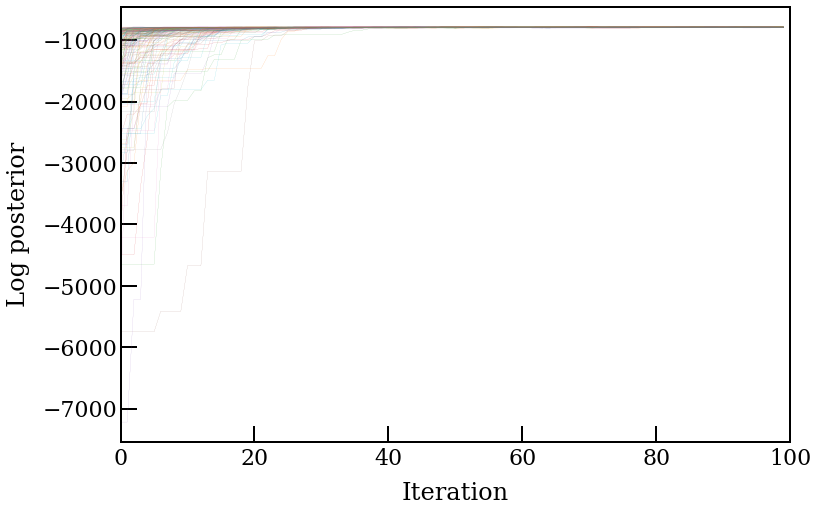

In [7]:
logp = context.sampler.get_log_prob()

for _logp in logp.T:
    plt.plot(_logp, lw=0.1)

plt.xlabel('Iteration')
plt.ylabel('Log posterior')
plt.xlim(0, 100)
plt.show()

In [8]:
logp = context.sampler.get_log_prob(flat=True)
chain = context.sampler.get_chain(flat=True)
mpe_parameters = chain[np.argmax(logp)]

par_manager = context.par_manager
par_manager.set_parameter_fit_from_array(mpe_parameters)
parameters = par_manager.get_all_parameter()

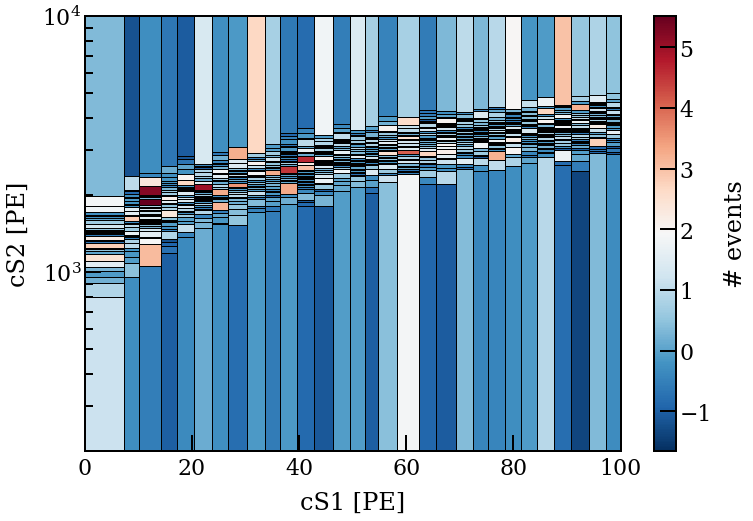

In [9]:
key = randgen.get_key()
key, model_hist = context.likelihoods['rn220_llh'].components['rn220_er'].simulate_hist(key, int(1e6), parameters)
model_hist += context.likelihoods['rn220_llh'].components['rn220_ac'].simulate_hist(parameters)
data_hist = context.likelihoods['rn220_llh'].data_hist

bins = context.likelihoods['rn220_llh'].components['rn220_er'].bins

apt.plot_irreg_histogram_2d(*bins, (model_hist-data_hist)/jnp.sqrt(data_hist))
plt.yscale('log')
plt.xlabel('cS1 [PE]')
plt.ylabel('cS2 [PE]')
plt.show()

In [10]:
from scipy.stats import chi2
t = jnp.sum(((model_hist-data_hist)/jnp.sqrt(data_hist))**2)
p = 1 - chi2.cdf(t, 30*30)
print(f'p = {p}')

p = 0.1371419330124919


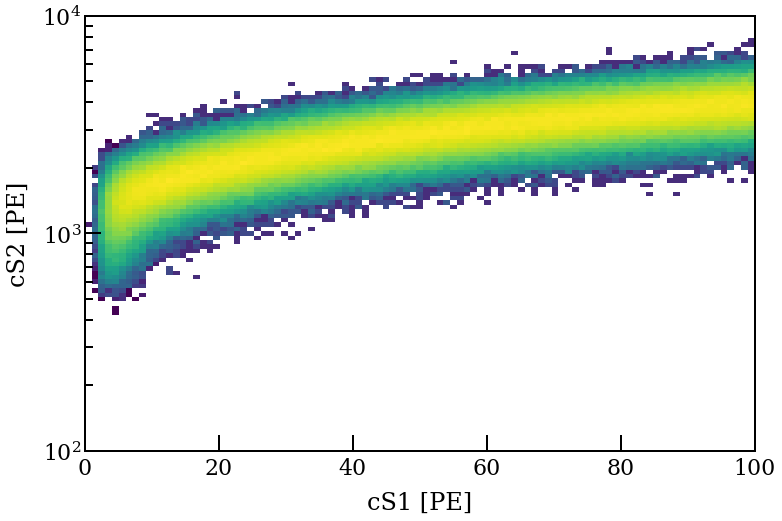

In [15]:
from matplotlib.colors import LogNorm

key = randgen.get_key()
key, (cs1, cs2, eff) = context.likelihoods['rn220_llh'].components['rn220_er'].simulate(key, int(1e6), parameters)

plt.hist2d(cs1, cs2, weights=eff, bins=[np.linspace(0, 100, 100), np.logspace(2, 4, 100)], norm=LogNorm())
plt.yscale('log')
plt.xlabel('cS1 [PE]')
plt.ylabel('cS2 [PE]')
plt.show()